# Land Cover Change Detection and Description in Austin, TX
In this notebook, we'll learn how to apply a land cover change detection model to Planet imagery captured over the greater Austin area. 
We will use the following process to achieve our goal:
   1. Initialize a Dask CUDA cluster to scale predictions on a GPU
   2. Load and pre-process two rasters that cover the greater Austin area (one from 2017 and the other from 2022)
   3. Apply a pre-trained PyTorch change detection model to chunks of the scene in parallel.

## Load Packages and Initialize Dask CUDA Cluster

In [1]:
import utils
import torch
from models.basic_model import CDEvaluator
import os
import numpy as np
import pandas as pd
from typing import TypedDict
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(threads_per_worker=4)
client = Client(cluster)
client

2022-06-13 15:01:24,132 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


<Client: 'tcp://127.0.0.1:34015' processes=1 threads=4, memory=83.59 GiB>

## Load pre-trained change detection model
The following cells load the pre-trained change detection model and sends the model parameters to the GPU to hold for processing.

In [2]:
args = utils.get_args()
utils.get_device(args)

In [3]:
def load_model():
    args.checkpoint_dir = os.path.join(args.checkpoint_root, args.project_name)
    model = CDEvaluator(args)
    model.load_checkpoint(args.checkpoint_name) 
    model.eval()
    return model
remote_model = client.submit(load_model)
print(remote_model)

<Future: pending, key: load_model-cb111a1f841fb24ff662dc6ff4c8c292>


## Load and pre-process Planet data
The following cell loads two rasters, one from May 2017 and the other from May 2022, and pre-processes them so that they can be passed into the change detection model. This data contains RGB and infrared, so we first remove the infrared band. We normalize each raster by subtracting the mean and dividing by the standard deviation. This helps the model by scaling the data into a range that the model has been trained on. In case the shape of the combined rasters won't produce equally-sized chunks, we cut off the last few pixels and only keep chunks that are of compatible size for loading onto the GPU. The combined dataset, **ds_comb** (2 years, 3 bands, x, y), holds all the data we are interested in - 2 years of RGB data over the area of interest. 

In [41]:
a = rio.vrt.WarpedVRT(rio.open('./catalogs/17_05/mosaic.tif'))
b = rio.vrt.WarpedVRT(rio.open('./catalogs/22_05/mosaic.tif'),transform=a.transform,height=a.height,width=a.width)

ds1 = rxr.open_rasterio(a,chunks=(4,8192,8192),lock=False)
ds2 = rxr.open_rasterio(b,chunks=(4,8192,8192),lock=False)

ds1 = ds1[:3]
ds2 = ds2[:3]

ds1 = ds1/255.0
ds2 = ds2/255.0

m1 = ds1.mean(axis=[1,2])
s1 = ds1.std(axis=[1,2])
m2 = ds2.mean(axis=[1,2])
s2 = ds2.std(axis=[1,2])

ds = xr.combine_nested([ds1,ds2],concat_dim="time")

bands = xr.DataArray([1,2,3],name="band",dims=["band"],coords={"band":[1,2,3]})

first_mu = xr.DataArray(m1.data,name="mean",coords=[bands])
first_std = xr.DataArray(s1.data,name="std",coords=[bands])
second_mu = xr.DataArray(m2.data,name="mean",coords=[bands])
second_std = xr.DataArray(s2.data,name="std",coords=[bands])

mean = xr.concat([first_mu,second_mu],dim="time")
std = xr.concat([first_std,second_std],dim="time")

normalized = (ds-mean)/std

slices = {}
for coord in ["y","x"]:
    remainder = len(ds.coords[coord])%32
    slice_ = slice(-remainder) if remainder else slice(None)
    slices[coord] = slice_

ds_comb = normalized.isel(**slices)

ds_comb = ds_comb.chunk((2,3,8192,8192))
ds_comb

<xarray.DataArray (time: 2, band: 3, y: 38848, x: 47200)>
dask.array<rechunk-merge, shape=(2, 3, 38848, 47200), dtype=float64, chunksize=(2, 3, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.568e+05 5.568e+05 ... 6.984e+05 6.984e+05
  * y            (y) float64 3.415e+06 3.415e+06 ... 3.298e+06 3.298e+06
    spatial_ref  int64 0
Dimensions without coordinates: time

## Predict geographic changes for entire scene
Given normalized data, we can now pass this data into our pre-trained model. For each Dask *chunk*, we will split it into small *chips* and pass each *chip* to the GPU for prediction. Our output is a binary mask for each chip. We stack each of these chips together to make a single mask for the entire scene, **predictions**.

In [42]:
import dask.array
from itertools import product
def predict_chips(data,model)->torch.Tensor:
    result = model._forward_pass(data).cpu().numpy()[0][0]
    return result

def copy_and_predict_chunked(tile,model,token=None):
    out = np.empty(shape=tile.shape[2:], dtype="uint8")
    device = torch.device("cuda")
    w,h = out.shape
    grid = product(range(0, h-h%256, 256), range(0, w-w%256, 256))
    for i,j in grid:
        A = torch.as_tensor(tile[0][np.newaxis,:,j:j+256,i:i+256])
        B = torch.as_tensor(tile[1][np.newaxis,:,j:j+256,i:i+256])
        gpu_chip = {'name':'test',
                    'A':A.float().to(device),
                    'B':B.float().to(device),
                    'L':torch.zeros(1,1,256,256).float().to(device)
               }
        out[j:j+256,i:i+256] = predict_chips(gpu_chip,model)
    return out

meta = np.array([[]], dtype="uint8")[:0]

predictions_array = ds_comb.data.map_blocks(
    copy_and_predict_chunked,
    meta=meta,
    drop_axis=[0,1],
    model=remote_model,
    name="predict",
)

predictions = xr.DataArray(
    predictions_array,
    coords=ds_comb.drop_vars("band").coords,
    dims=("y", "x"),
)
predictions

<xarray.DataArray 'predict-782a63ace4c5e164285684e0edd88d96' (y: 38848, x: 47200)>
dask.array<predict, shape=(38848, 47200), dtype=uint8, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.568e+05 5.568e+05 ... 6.984e+05 6.984e+05
  * y            (y) float64 3.415e+06 3.415e+06 ... 3.298e+06 3.298e+06
    spatial_ref  int64 0

## Visualize some of the results!
The entire dataset contains ~ 140 km x 120 km of data. This takes several minutes to process. Let's check out a subset of the data before we try to run the entire scene.
The following cell grabs a 5000 x 5000 snippet of the large dataset so we can visualize change detection in a quick demo.

In [43]:
middle = ds.shape[2] // 2, ds.shape[3] // 2
slice_y = slice(middle[0], middle[0]+5000)
slice_x = slice(middle[1], middle[1]+5000)

parts = [x.isel(y=slice_y, x=slice_x) for x in [ds, predictions, normalized]]

Now that we have a small slice of the data, we can pass the data to the GPU for prediction. Watch the Dask Task Graph and Progress when executing the following cell. This is where the *magic* happens!

In [44]:
ds_local, predictions_local, norm_local = dask.compute(*parts)

In [45]:
import matplotlib.colors
from bokeh.models.tools import BoxZoomTool
import panel
import hvplot.xarray

def logo(plot, element):
    plot.state.toolbar.logo = None


zoom = BoxZoomTool(match_aspect=True)
style_kwargs = dict(
    width=450,
    height=400,
    xaxis=False,
    yaxis=False,
)
kwargs = dict(
    x="x",
    y="y",
    rasterize=True,
    cmap='gray',
    aggregator="min",
    colorbar=False,
    tools=["pan", zoom, "wheel_zoom", "reset"],
)

In [46]:
panel.Column(
    panel.Row(
        ds_local.sel(time=0)
        .hvplot.rgb(
            bands="band", rasterize=True, hover=False, title="Austin 05_17", tools=["pan", zoom, "wheel_zoom", "reset"], **style_kwargs
        )
        .opts(default_tools=[], hooks=[logo]),
        predictions_local
        .hvplot.image(title="Changes", **kwargs, **style_kwargs)
        .opts(default_tools=[]),
        ds_local.sel(time=1)
        .hvplot.rgb(
            bands="band",
            rasterize=True,
            hover=False,
            title="Austin 05_22",
            tools=["pan", zoom, "wheel_zoom", "reset"],
            **style_kwargs,
        )
        .opts(default_tools=[], hooks=[logo]),
    ),
)

Column
    [0] Row
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)
        [2] HoloViews(DynamicMap)

## Analyze the change mask
We want to analyze the areas of change, so let's *polygonize* the mask so that it's easier to deal with for further tasks. We will also find the centroid of areas with the largest contiguous changes and pass those into a pre-trained classifier to look at changes in outputs.

In [195]:
from fastai.vision import *
from xrspatial.experimental import polygonize
import geopandas as gpd
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from skimage.io import imread, imshow
from shapely.geometry import Point

In [34]:
learner = load_learner('../2750/')

In [225]:
knl = np.ones((3,3))
def multi_dil(im, num, element=knl):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=knl):
    for i in range(num):
        im = erosion(im, element)
    return im

dilated = multi_dil(predictions_local,7)
closed = area_closing(dilated, 50000)
multi_eroded = multi_ero(closed, 7)
opened = opening(multi_eroded)
label_im = label(opened)
regions = regionprops(label_im)

df = pd.DataFrame(regionprops_table(label_im,properties=['centroid','area']))
df = df.rename(columns={"centroid-0":"y","centroid-1":"x"})
df = df.astype({'x':'int32','y':'int32'})
df = df.loc[df['area']>5]
df = df.sort_values(by='area',ascending=False)
df = df.reset_index(drop=True)
df = df.head()

geos = []
for index,row in df.iterrows():
    geos.append(Point(ds_local.coords["x"][row["x"]].item(),ds_local.coords["y"][row["y"]].item()))
df['geometry'] = geos
gdf = gpd.GeoDataFrame(df,crs=32614)
gdf = gdf.loc[1:,:]
gdf.head()

/opt/conda/envs/planet-fastai/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


y     x   area                        geometry
1   148  2452  81061  POINT (634948.500 3356191.500)
2  1493  3968  57112  POINT (639496.500 3352156.500)
3  4503  1435  39908  POINT (631897.500 3343126.500)
4   302  2006  39859  POINT (633610.500 3355729.500)

### Visual spot checking
Before we hurry to use another ML model, let's visually check that the change mask is corresponding to visual changes in the data.

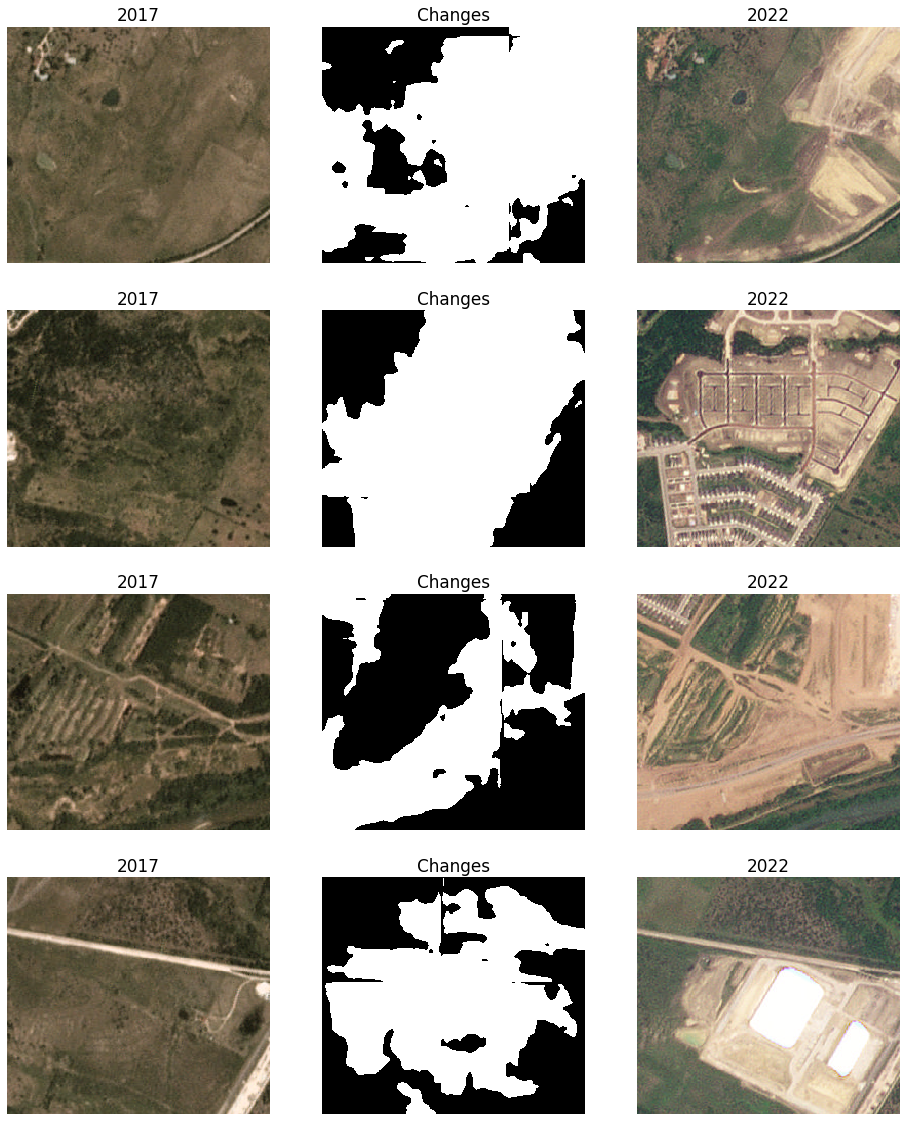

In [228]:
ims_17 = []
norm_17 = []
ims_22 = []
norm_22 = []
changes = []
# keep = []
for index,row in gdf.iterrows():
    temp_17 = ds_local[0,:3,row['y']-128:row['y']+128,row['x']-128:row['x']+128]
    norm_temp_17 = norm_local[0,:3,row['y']-128:row['y']+128,row['x']-128:row['x']+128]
    temp_22 = ds_local[1,:3,row['y']-128:row['y']+128,row['x']-128:row['x']+128]
    norm_temp_22 = norm_local[1,:3,row['y']-128:row['y']+128,row['x']-128:row['x']+128]
    change_temp = predictions_local[row['y']-128:row['y']+128,row['x']-128:row['x']+128]
    if temp_17.shape[1]==0 or temp_17.shape[2]==0 or temp_22.shape[1]==0 or temp_22.shape[2]==0:
        # keep.append(0)
        pass
    else:
        ims_17.append(temp_17)
        norm_17.append(norm_temp_17)
        ims_22.append(temp_22)
        norm_22.append(norm_temp_22)
        changes.append(change_temp)
#         keep.append(1)
# keep = np.array(keep)
# gdf = gdf.loc[keep==1,:]
fig, axs = plt.subplots(4,3,figsize=(16,20))
for i in range(4):
    ims_17[i].plot.imshow(ax=axs[i][0])
    changes[i].plot.imshow(ax=axs[i][1],add_colorbar=False,cmap='gray')
    ims_22[i].plot.imshow(ax=axs[i][2])
    axs[i][0].axis('off')
    axs[i][0].title.set_text('2017')
    axs[i][1].axis('off')
    axs[i][1].title.set_text('Changes')
    axs[i][2].axis('off')
    axs[i][2].title.set_text('2022')    
plt.rcParams.update({'font.size': 14})
plt.show()

### Classifying changes
Now that we have verified that our pre-trained change detection model is accurately detecting changes that have occurred, let's use a classifer to label each patch of interest.

In [229]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
pred_17 = []
conf_17 = []
pred_22 = []
conf_22 = []
transform = T.Compose([T.ToPILImage(),
                       T.CenterCrop((224,224)),
                       T.ToTensor(),
                   ])
for i in range(len(gdf)):
    temp_2017 = ims_17[i].data
    temp_2022 = ims_22[i].data
    torch_2017 = transform(torch.from_numpy(temp_2017))
    torch_2022 = transform(torch.from_numpy(temp_2022))
    temp_2017 = Image(torch_2017.float())
    temp_2022 = Image(torch_2022.float())
    p_17 = learner.predict(temp_2017)
    p_22 = learner.predict(temp_2022)
    pred_17.append(p_17[1].item())
    conf_17.append(p_17[2][p_17[1].item()].item())
    pred_22.append(p_22[1].item())
    conf_22.append(p_22[2][p_22[1].item()].item())
gdf = gdf.assign(pred_17=[learner.data.classes[x] for x in pred_17],conf_17=conf_17,pred_22=[learner.data.classes[x] for x in pred_22],conf_22=conf_22)
gdf

y     x   area                        geometry               pred_17  \
1   148  2452  81061  POINT (634948.500 3356191.500)  HerbaceousVegetation   
2  1493  3968  57112  POINT (639496.500 3352156.500)         PermanentCrop   
3  4503  1435  39908  POINT (631897.500 3343126.500)  HerbaceousVegetation   
4   302  2006  39859  POINT (633610.500 3355729.500)         PermanentCrop   

    conf_17        pred_22   conf_22  
1  0.742841  PermanentCrop  0.960786  
2  0.754613     Industrial  0.271968  
3  0.589747        Highway  0.910287  
4  0.918615     Industrial  0.999707

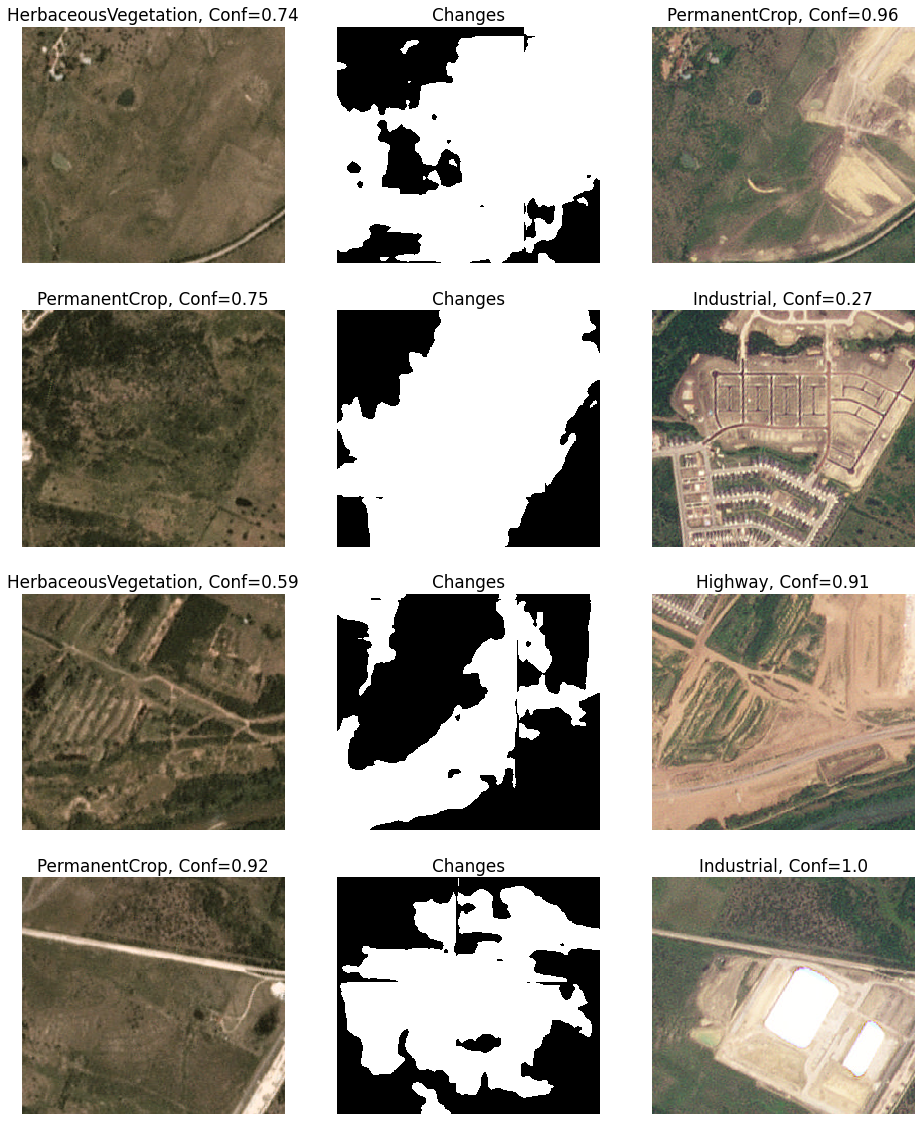

In [230]:
fig, axs = plt.subplots(4,3,figsize=(16,20))
for i in range(4):
    ims_17[i].plot.imshow(ax=axs[i][0])
    changes[i].plot.imshow(ax=axs[i][1],add_colorbar=False,cmap='gray')
    ims_22[i].plot.imshow(ax=axs[i][2])
    axs[i][0].axis('off')
    axs[i][0].title.set_text(gdf.iloc[i]['pred_17']+", Conf="+str(round(gdf.iloc[i]['conf_17'],2)))
    axs[i][1].axis('off')
    axs[i][1].title.set_text('Changes')
    axs[i][2].axis('off')
    axs[i][2].title.set_text(gdf.iloc[i]['pred_22']+", Conf="+str(round(gdf.iloc[i]['conf_22'],2)))    
plt.rcParams.update({'font.size': 12})
plt.show()